In [2]:
# This stuff is RAM intensive - just run on 00 or 05!
from IPython import get_ipython
import os
import warnings
import numpy as np
import sys
import shutil

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tifffile import imread as tif_imread
from tifffile import imsave as tif_imsave
from tifffile import imwrite as tif_imwrite
from skimage import measure as sm

from copy import deepcopy

from scipy import interpolate as si
from skimage import measure as sm
from skimage import transform as st

#import largestinteriorrectangle as lir
from tqdm.auto import tqdm,trange

from pathlib import Path
import pickle

import cv2
import multiprocessing
from joblib import Parallel, delayed

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

In [2]:
# first test group
prob_paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [2]:
# making prob_movies for all outputs
#in vivo group 1
prob_paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG43PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231029_DG58PL64/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231027_DG57PL69/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231019_DG53PL68/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231017_DG49PL70/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/wells/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230908_PK109PL52/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230908_PK109PL52/wells/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230907_PK108PL54/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230904_PS54PL60/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230904_PS54PL60/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230901_DG89PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230901_DG89PL32/wells/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [2]:
# slice runs
# dipping runs group 1 2023 8/19-9/27
prob_paths = ['/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230830_SL2PL60/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL3PL61/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL2PL39/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL2PL54/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL3PL58/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL1PL32/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL2PL60/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL2PL34/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL1PL52/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL2PL39/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230608_SL2PL45/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230608_SL1PL37/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL2PL42/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/washes/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230511_DA2PL45/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230511_DA1PL37/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230511_DA1PL37/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA2PL55/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells401/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells501/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells401/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells401/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells501/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells401/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL56/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL56/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL56/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells401/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells501/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells001/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells101/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells201/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells301/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells401/segtrack/segs/ch0/31_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230825_PL57/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230825_PL39/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL61/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL48/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells201/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230821_PL57/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL62/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells201/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [7]:
# in vivo runs group 2 2023 5/19-2022 9/1 ch0 only

prob_paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/230810_DG87PL55/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230810_DG87PL55/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230809_DG86PL57/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230809_DG86PL57/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230808_DG85PL61/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230808_DG85PL61/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230807_DG84PL52/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230807_DG84PL52/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230802_DG48PL58/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230802_DG48PL58/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230728_DG80PL57/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230727_DG79PL59/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230726_DG47PL54/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230726_DG47PL54/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230721_DG46PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230721_DG46PL32/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230720_PK97PL48/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230720_PK97PL48/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230714_PK95PL55/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230713_PK94PL59/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230713_PK94PL59/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230712_PK93PL57/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230712_PK93PL57/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230711_DG44PL47/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230711_DG44PL47/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230711_DG43PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230708_DG70PL56/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230708_DG70PL56/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230706_DG71PL54/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             #'/mnt/nasquatch/data/2p/peter/in_vivo/230706_DG71PL54/mouse2/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230706_DG71PL54/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230615_DG69PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230615_DG69PL32/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230614_DG63PL54/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230614_DG63PL54/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230601_PK85PL53/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230601_PK85PL53/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230531_PK80PL43/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230531_PK80PL43/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230526_PK84PL50/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230526_PK84PL50/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230525_DG42PL39/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230525_DG42PL39/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230519_DG41PL52/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230519_DG41PL52/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221204_PS39PL51/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221204_PS39PL51/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221203_PS45PL50/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221203_PS45PL50/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221125_PS39PL50/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221125_PS39PL50/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221111_PS28PL41/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221111_PS28PL41/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221109_PS27PL28/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221109_PS27PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221107_PS23PL42/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221020_PS16PL39/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221020_PS16PL39/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221018_PS10PL24/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/221018_PS10PL24/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220929_PS11PL37/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220928_PK65PL30/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220927_PK60PL33/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220916_PK66PL28/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220916_PK66PL28/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220913_PK65PL32/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220902_PK61PL37/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220902_PK61PL37/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220901_PK60PL36/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220901_PK60PL36/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [6]:
# in vivo runs group 3 2022 7/1 back; dipping 2022 peter ch0 only

prob_paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220629_PK46PL25/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220629_PK46PL25/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220628_PK45PL24/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220621_PK24PL13/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220621_PK24PL13/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220617_PK26PL18/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220617_PK26PL18/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220616_PK25PL9/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220615_PK24PL18/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220530_PK25PL9/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220530_PK25PL9/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220519_PK43PL17/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220519_PK43PL17/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220518_PK40PL14/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220515_PK27PL13/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220514_PK26PL6/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220514_PK26PL6/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220512_PK24PL19/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220506_PK26PL16/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220504_PK24PL9/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220504_PK24PL9/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220427_PK27PL20/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220427_PK27PL20/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220423_PK24PL17/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220407_PK26PL15/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220407_PK26PL15/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220406_PK24PL10/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220406_PK24PL10/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220318_PK24PL14/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220318_PK24PL14/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220316_PK32PL13/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220316_PK32PL13/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220315_PK36PL18/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220315_PK36PL18/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220314_PL14BCH/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220303_PK26PL21/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220303_PK26PL21/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220302_PK27PL13/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220223_PK26PL19/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220217_PK27PL13/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220217_PK26PL15/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221129_PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221129_PL28/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221118_PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221116_PL44/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221115_PL42/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221115_PL42/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221115_PL42/wells201/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221104_PL45/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221103_PL47/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221103_PL38/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221102_PL44/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221102_PL44/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221101_PL42/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221101_PL42/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221014_PL36/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221014_PL36/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221013_PL33/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20221013_PL33/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220930_PL34/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220930_PL34/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220921_PL25/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220921_PL25/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220915_PL29/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220915_PL29/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220914_PL21/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220914_PL21/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220907_PL27/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220907_PL27/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220906_PL24/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220906_PL24/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220831_PL31/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220831_PL27/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220830_PL32/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220830_PL24/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220825_PL29/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220825_PL18/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220824_PL33/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220824_PL13/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220823_PL32/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220823_PL24/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220819_PL23/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220819_PL22/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220817_PL31/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220817_PL27/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220816_PL24/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220812_PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220812_PL22/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220811_PL30/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220811_PL18/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220810_PL27/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220810_PL20/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220809_PL24/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220809_PL14/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220729_PL27/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220728_PL24/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220727_PL14/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220707_PL18/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20220705_PL9/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [2]:
prob_paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/wells101/segtrack/segs/ch0/52_mean_warped_fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001/segtrack/segs/ch0/52_mean_warped_fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [16]:
# dipping runs group 1 2023 8/19-9/27 warp ch0!
prob_paths = ['/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells401/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells501/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells401/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells401/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells501/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells401/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL56/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL56/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL56/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells401/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells501/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells001/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells201/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells301/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells401/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230825_PL57/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230825_PL39/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL61/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL48/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells201/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230821_PL57/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL62/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/dipping/20230819_PL43/wells201/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [125]:
# additional slice/in vivo to warp to ch0
prob_paths = ['/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [144]:
# unpaired slice ch0 option
prob_paths = ['/mnt/nasquatch/data/2p/peter/slice/20230830_SL2PL60/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL3PL61/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230829_SL2PL39/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230824_SL2PL54/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL3PL58/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL1PL32/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [4]:
# extras 20241201
prob_paths = ['/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well9/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well3/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well6/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well9/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well8/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well2/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well5/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well8/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211103_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211104_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211109_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211110_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211111_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211112_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211121_PZ1/chunks/well7/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
        '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well1/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well4/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/chip_tiling/211123_PZ1/chunks/well7/segtrack/segs/ch0/10_mean__fix/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG43PL32/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/wells201/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231029_DG58PL64/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231027_DG57PL69/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231019_DG53PL68/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/231017_DG49PL70/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230908_PK109PL52/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230908_PK109PL52/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230907_PK108PL54/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells101/segtrack/segs/ch0/31_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230904_PS54PL60/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230904_PS54PL60/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230901_DG89PL32/wells101/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg',
         '/mnt/nasquatch/data/2p/peter/in_vivo/230901_DG89PL32/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg']

In [5]:
%%time
# make means_movies
# ~0.5 sec/frame - not much to parallelize here, mainly a data loading/saving task - ~4 min per ~170 frame movie
means_paths = []
means_paths2 = []
for prob_path in tqdm(prob_paths):
    means_paths2.append(Path(prob_path.replace('segs','tiffs')).parent.parent)
[means_paths.append(x) for x in means_paths2 if x not in means_paths]

for means_path in tqdm(means_paths):
    means_movie = []
    
    frnum = len([nm for nm in os.listdir(means_path) if nm[:5] == 'image'])
    
    for t in trange(1,frnum+1):
        means = tif_imread(f'{means_path}/image{t:03d}.tiff')
        means_movie.append(np.array(means))

    np.save(f'{means_path}/means_movie.npy',np.array(means_movie))
    #del means_movie
    #tif_imsave(f'{means_path}/means_movie.tiff',  
    #           np.array(means_movie).astype('float32'), bigtiff=True, imagej=True,metadata={'axes': 'TZYX'}, compression ='zlib')

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

CPU times: user 2min 8s, sys: 13min 33s, total: 15min 41s
Wall time: 6h 19min 24s


In [6]:
%%time
# make prob_movies and max projections (with Gaussian blur)
# ~0.5 sec/frame - again not much to parallelize, data loading/saving
# relatively slow, RAM intensive! stop making normalized probmap stuff
sigmas = [0,1,1]

for prob_path in tqdm(prob_paths):
    prob_movie = []
    prob_movie_norm = []
    
    frnum = len([nm for nm in os.listdir(prob_path) if nm[:5] == 'prob0'])
    
    for t in trange(1,frnum+1):
        prob_map = np.load(f'{prob_path}/prob{t:04d}.npy')
        #prob_map_norm = (prob_map - prob_map.min()) / (prob_map.max() - prob_map.min())
        prob_map = np.transpose(prob_map,(2,0,1))
        #prob_map_norm = np.transpose(prob_map_norm,(2,0,1))
        prob_movie.append(np.array(prob_map))
        #prob_movie_norm.append(np.array(prob_map_norm))

    prob_movie_arr = np.array(prob_movie)
    #prob_movie_norm_arr = np.array(prob_movie_norm)
    prob_movie_arr_max = gaussian_filter(np.max(prob_movie_arr,axis=0),sigma=sigmas,mode='nearest')
    
    np.save(f'{prob_path}/prob_movie.npy',prob_movie_arr)
    #np.save(f'{prob_path}/prob_movie_norm.npy',prob_movie_norm_arr)
    tif_imwrite(f'{prob_path}/prob_movie_tmax_blur.tiff',  
           prob_movie_arr_max.astype('float32'), bigtiff=True, imagej=True,metadata={'axes': 'ZYX'}, compression ='zlib')
    tif_imwrite(f'{prob_path}/prob_movie.tiff',  
           np.array(prob_movie).astype('float32'), bigtiff=True, imagej=True,metadata={'axes': 'TZYX'}, compression ='zlib')
    #tif_imwrite(f'{prob_path}/prob_movie_norm.tiff',  
    #       np.array(prob_movie_norm).astype('float32'), bigtiff=True, imagej=True,metadata={'axes': 'TZYX'}, compression ='zlib')

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

/mnt/colab/colab_shared/anaconda3/lib/python3.9/site-packages/tifffile/tifffile.py:1095: UserWarning: TiffWriter: writing nonconformant BigTIFF ImageJ
  warnings.warn(


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

CPU times: user 1h 26min 26s, sys: 17min 6s, total: 1h 43min 33s
Wall time: 5h 55min 32s


In [7]:
%%time
# make coord_movies
for coord_path in tqdm(prob_paths):
    coord_centroid_movie = []
    coord_com_movie = []
    frnum = len([nm for nm in os.listdir(coord_path) if nm[:5] == 'prob0'])
    #coord_path = '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/segtrack/segs/ch1/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso5_st0p4_blTrue_intFalse_3DeeC/seg'
    for t in trange(1,frnum+1):
        try:
            coord_centroid_map = np.load(f'{coord_path}/coordscentroid{t:04d}.npy')
            coord_com_map = np.load(f'{coord_path}/coordsprobcom{t:04d}.npy')
            coord_centroid_movie.append(np.array(coord_centroid_map))
            coord_com_movie.append(np.array(coord_com_map))
        except:
            break
    
    coord_3d_centroid_movie = []
    coord_3d_com_movie = []

    for t in trange(0,len(coord_centroid_movie)):
        coord_3d_centroid_movie_t = np.zeros(prob_movie[0].shape,dtype='uint8')
        for c in range(0,len(coord_centroid_movie[t])):
            for x in range(max(round(coord_centroid_movie[t][c,0]-1),0),min(round(coord_centroid_movie[t][c,0]+2),coord_3d_centroid_movie_t.shape[1])):
                for y in range(max(round(coord_centroid_movie[t][c,1]-1),0),min(round(coord_centroid_movie[t][c,1]+2),coord_3d_centroid_movie_t.shape[2])):
                    for z in range(max(round(coord_centroid_movie[t][c,2]-1),0),min(round(coord_centroid_movie[t][c,2]+2),coord_3d_centroid_movie_t.shape[0])):
                        coord_3d_centroid_movie_t[z,x,y] = c
        coord_3d_centroid_movie.append(np.array(coord_3d_centroid_movie_t))
                    
    for t in trange(0,len(coord_com_movie)):
        coord_3d_com_movie_t = np.zeros(prob_movie[0].shape,dtype='uint8')
        for c in range(0,len(coord_com_movie[t])):
            for x in range(max(round(coord_com_movie[t][c,0]-1),0),min(round(coord_com_movie[t][c,0]+2),coord_3d_com_movie_t.shape[1])):
                for y in range(max(round(coord_com_movie[t][c,1]-1),0),min(round(coord_com_movie[t][c,1]+2),coord_3d_com_movie_t.shape[2])):
                    for z in range(max(round(coord_com_movie[t][c,2]-1),0),min(round(coord_com_movie[t][c,2]+2),coord_3d_com_movie_t.shape[0])):
                        coord_3d_com_movie_t[z,x,y] = c
        coord_3d_com_movie.append(np.array(coord_3d_com_movie_t))

#path = r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso5_st0p4_blTrue_intFalse_3DeeC/seg'
    tif_imwrite(f'{coord_path}/coord_3d_centroid_movie.tiff',  
               np.array(coord_3d_centroid_movie).astype('uint16'), imagej=True,metadata={'axes': 'TZYX'}, compression ='zlib')
    tif_imwrite(f'{coord_path}/coord_3d_com_movie.tiff',  
               np.array(coord_3d_com_movie).astype('uint16'), imagej=True,metadata={'axes': 'TZYX'}, compression ='zlib')

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/mnt/colab/colab_shared/anaconda3/lib/python3.9/site-packages/tifffile/tifffile.py:1570: UserWarning: TiffWriter: writing zero size array to nonconformant TIFF
  warnings.warn(


ValueError: ImageJ hyperstack shape and axes do not match

In [ ]:
# FIXING TMAX_BLUR FOR BAD WARPS!!

In [148]:
prob_paths = ['/mnt/nasquatch/data/2p/peter/slice/20230830_SL2PL60/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL3PL58/slice/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/mouse/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL2PL39/slice/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/']

frstarts = [None,
           None,
           33,
           10,
           None,
           5,
           None,
           None,
           6,
           None,
           None,
           None]

frends = [42,
         45,
         75,
         None,
         120,
         None,
         165,
         15,
         None,
         156,
         75,
         40]

In [132]:
prob_paths = ['/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells201/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/']

frstarts = [None]

frends = [89]

In [128]:
prob_paths = ['/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001/segtrack/segs/ch0/52_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/']

frstarts = [10,
           20,
           None,
           None,
           10,
           None]

frends = [80,
         None,
         130,
         155,
         None,
         81]

In [ ]:
prob_paths = ['/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/wells001/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/wells101/segtrack/segs/ch0/52_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/']

frstarts = [None,
          None]

frends = [22,
         70]

In [149]:
%%time
sigmas = [0,1,1]

for m in trange(0,len(prob_paths)):
    prob_path = prob_paths[m]
    prob_movie = []
    prob_movie_norm = []
    
    frstart = frstarts[m]
    frend = frends[m]
    if frstart is None:
        frstart = 1
    if frend is None:
        frend = len([nm for nm in os.listdir(prob_path) if nm[:5] == 'prob0'])
    
    for t in trange(frstart,frend+1):
        prob_map = np.load(f'{prob_path}/prob{t:04d}.npy')
        #prob_map_norm = (prob_map - prob_map.min()) / (prob_map.max() - prob_map.min())
        prob_map = np.transpose(prob_map,(2,0,1))
        #prob_map_norm = np.transpose(prob_map_norm,(2,0,1))
        prob_movie.append(np.array(prob_map))
        #prob_movie_norm.append(np.array(prob_map_norm))

    prob_movie_arr = np.array(prob_movie)
    #prob_movie_norm_arr = np.array(prob_movie_norm)
    prob_movie_arr_max = gaussian_filter(np.max(prob_movie_arr,axis=0),sigma=sigmas,mode='nearest')

    tif_imwrite(f'{prob_path}/prob_movie_tmax_blur.tiff',  
           prob_movie_arr_max.astype('float32'), bigtiff=True, imagej=True,metadata={'axes': 'ZYX'}, compression ='zlib')

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 1min 8s, sys: 1min 19s, total: 2min 27s
Wall time: 10min 28s


In [ ]:
# Bigstitcher/bigwarp preprocessing
# 1. Generate bigstitcher inputs - correct reference planes in correct folder, nothing fancy
# 2. Generate bigwarp inputs - reference planes correctly rotated and ?with RGB COM overlay

In [157]:
# previously missed in vivos
# 22/ 4/6, 4/27, 10/18
# 23/ 5/19, 5/25, 5/26, 7/26, 8/2, 8/10
ref_frames_l = [[40,57],
               [77,80],
               [31,20],
               [71,1],
               [70,1],
               [62,1],
               [71,30],
               [71,57],
               [94,48]]
data_dirs_l = [['/mnt/nasquatch/data/2p/peter/in_vivo/220406_PK24PL10/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/220406_PK24PL10/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/220427_PK27PL20/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/220427_PK27PL20/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/221018_PS10PL24/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/221018_PS10PL24/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/230519_DG41PL52/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/230519_DG41PL52/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/230525_DG42PL39/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/230525_DG42PL39/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/230526_PK84PL50/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/230526_PK84PL50/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/230726_DG47PL54/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/230726_DG47PL54/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/230802_DG48PL58/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/230802_DG48PL58/wells101'],
              ['/mnt/nasquatch/data/2p/peter/in_vivo/230810_DG87PL55/mouse',
               '/mnt/nasquatch/data/2p/peter/in_vivo/230810_DG87PL55/wells101']]

zmt_l = [[(3,26,52,10,None),(3,27,52,0,None)],
        [(2,25,52,10,None),(7,28,52,0,153)],
        [(2,26,52,0,62),(7,27,52,0,174)],
        [(3,26,52,5,None),(9,27,52,0,51)],
        [(4,23,52,0,None),(10,27,52,0,18)],
        [(3,24,52,0,None),(11,27,52,0,24)],
        [(4,27,52,0,None),(3,23,52,0,45)],
        [(4,27,52,0,None),(5,26,52,0,None)],
        [(3,26,52,0,None),(4,27,52,0,None)]]

warp_ch0_l = [[False for i in range(len(x))] for x in ref_frames_l]

In [153]:
# remaining in vivos and unpaired slices
# in vivo and unpaired slices using ch1
ref_frames_l = [[28],
               [28],
               [28],
               [62,45],
               [62,100],
               [76,115],
               [70,1],
               [67,60],
               [55,115],
               [71,54],
               [71,40],
               [70,50],
               [73,48],
               [28],
               [33],
               [28],
               [27],
               [27],
               [18],
               [18],
               [26],
               [18],
               [25],
               [18],
               [16]]
data_dirs_l = [['/mnt/nasquatch/data/2p/peter/slice/20230830_SL2PL60/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230829_SL2PL39/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230822_SL3PL58/slice'], #threse three ch0 True
             ['/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220216_PK25PL8/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220311_PK24PL9/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220622_PK44PL17/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220624_PK45PL13/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/220901_PK60PL36/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220901_PK60PL36/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/220903_PK63PL34/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/230615_DG69PL32/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230615_DG69PL32/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230617_DG70PL54/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/230720_PK97PL48/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230720_PK97PL48/wells101'],
             ['/mnt/nasquatch/data/2p/peter/in_vivo/230807_DG84PL52/mouse',
             '/mnt/nasquatch/data/2p/peter/in_vivo/230807_DG84PL52/wells101'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230829_SL3PL61/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230824_SL2PL54/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230822_SL1PL32/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230817_SL2PL60/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230801_SL2PL34/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230727_SL1PL52/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230616_SL2PL39/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230608_SL2PL45/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230608_SL1PL37/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230607_SL2PL42/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230511_DA2PL45/slice'],
             ['/mnt/nasquatch/data/2p/peter/slice/20230509_DA2PL55/slice']]
zmt_l = [[(2,26,52,0,42)],
        [(2,27,52,0,None)],
        [(2,25,52,0,45)],
        [(2,27,52,0,None),(3,27,52,33,75)],
        [(2,26,52,10,None),(5,25,52,0,120)],
        [(4,26,52,5,None),(3,26,52,0,165)],
        [(3,27,52,0,None),(1,26,52,0,15)],
        [(2,25,52,0,None),(9,27,52,0,None)],
        [(2,26,52,6,None),(3,25,52,0,156)],
        [(2,27,52,0,None),(3,27,52,0,None)],
        [(3,27,52,0,None),(2,26,52,0,75)],
        [(4,26,52,0,None),(5,27,52,0,None)],
        [(2,26,52,0,None),(5,27,52,0,None)],
        [(2,27,52,0,None)],
        [(2,27,52,0,None)],
        [(2,26,52,0,None)],
        [(3,27,52,0,None)],
        [(3,27,52,0,None)],
        [(2,26,52,0,None)],
        [(2,25,52,0,40)],
        [(8,27,52,0,None)],
        [(2,27,52,0,None)],
        [(2,26,52,0,None)],
        [(2,26,52,0,None)],
        [(1,17,52,0,None)]]

warp_ch0_l = [[True for i in range(len(x))] for x in data_dirs_l[:3]] + [[False for i in range(len(x))] for x in data_dirs_l[3:]]

In [138]:
#dipping warps - all ch0 (including rerun of 0922 wells006)
#slice and in vivo ch0 warp reruns!
#changed to warped_ch0 option throughout code!
ref_frames_l = [[25,31,30,30],
             [20,35,37,30],
             [25,25,32,35,30,31],
             [30,15,37,31,31],
             [25,37,37,26,36,31],
             [15,35,15,15,40],
             [25,15,20,40],
             [18,13,25,19,15,35],
             [25,40],
             [18,15,31,25,19],
             [18,15,46]]

zmt_l = [[(3,26,31,0,None),(3,27,31,0,None),(4,27,31,0,None),(4,27,31,0,None)],
        [(2,27,31,0,None),(3,27,31,0,None),(3,26,31,0,None),(3,27,31,0,None)],
        [(2,26,31,0,None),(3,27,31,0,None),(3,26,31,0,None),(3,27,31,0,None),(2,26,31,0,None),(3,27,31,0,None)],
        [(2,27,31,0,None),(3,25,31,0,None),(5,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None)],
        [(2,26,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,26,31,0,None),(2,26,31,0,None),(3,27,31,0,None)],
        [(3,27,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(2,26,31,0,None)],
        [(3,26,31,0,None),(3,26,31,0,None),(4,27,31,0,None),(3,26,31,0,None)],
        [(3,26,31,0,None),(3,25,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(3,27,31,0,None)],
        [(2,26,31,0,None),(3,27,31,0,None)],
        [(4,26,31,0,None),(2,27,31,0,None),(3,26,31,0,None),(2,27,31,0,None),(3,27,31,0,None)],
        [(2,26,52,0,None),(2,26,52,0,None),(5,25,52,0,89)]]

warp_ch0_l = [[True for i in range(len(x))] for x in ref_frames_l]

data_dirs_l = [['/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells301'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells301'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells401',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells501'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells401'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells401',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells501'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells301'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells401',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells501'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells101'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells401'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells201']]

In [130]:
#slice and in vivo ch0 warp reruns!
#changed to warped_ch0 option throughout code!
warp_ch0_l = [[True,False],
             [True,False],
             [True,False],
             [True,True],
             [True,False],
             [True,True],
             [True,True],
             [False,True],
             [False,True],
             [True,False,True],
             [False,True]]

data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001']]

ref_frames_l = [[49,34],
             [85,34],
             [71,34],
             [71,34],
             [60,34],
             [89,34],
             [75,38],
             [28,52],
             [28,52],
             [22,18,20],
             [28,52]]

zmt_l = [[(3,27,52,10,80),(3,26,52,0,None)],
        [(6,26,52,20,None),(3,25,52,0,None)],
        [(4,27,52,0,130),(2,26,52,0,None)],
        [(4,26,52,0,None),(5,27,52,0,None),],
        [(3,27,52,0,None),(3,25,31,3,None)],
        [(3,27,52,0,155),(2,26,52,0,None)],
        [(3,27,52,10,None),(3,27,52,0,None)],
        [(1,27,52,0,None),(6,23,52,0,None)],
        [(1,27,52,0,42),(3,25,52,0,None)],
        [(3,25,52,0,None),(3,26,52,0,None),(2,26,52,0,None)],
        [(1,27,52,0,None),(3,27,52,0,81)]]

In [6]:
# more complete version with parameters for lir
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells'],
            #[r'/mnt/nasquatch/data/2p/peter/in_vivo/231017_DG49PL70/mouse'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101']]

ref_frames_l = [[85,1],
             [85,34],
             [85,34],
             [85,34],
             [85,34],
             [49,34],
             [85,34],
             [71,34],
             [71,34],
             #[71],
             [71,34],
             [60,34],
             [89,34],
             [75,38],
             [28,52],
             [28,52],
             [28,52],
             [22,18,20],
             [28,52],
             [27,18,39]]

zmt_l = [[(5,26,52,0,None),(8,24,52,0,None)],
        [(4,27,52,0,None),(4,26,52,0,None)],
        [(3,27,52,0,None),(3,24,52,0,None)],
        [(6,27,52,0,None),(2,26,52,0,None)],
        [(5,27,52,0,None),(2,26,52,0,None)],
        [(3,26,52,10,None),(3,26,52,0,None)],
        [(5,25,52,15,None),(3,25,52,0,None)],
        [(5,26,52,0,None),(2,26,52,0,None)],
        [(6,26,52,0,None),(4,27,52,0,None)],
        #[(3,27,52,0,None)],
        [(5,27,52,10,None),(2,26,31,0,None)],
        [(4,27,52,0,None),(3,25,31,0,None)],
        [(5,27,52,0,155),(1,25,52,0,None)],
        [(5,27,52,0,None),(2,27,52,0,None)],
        [(1,27,52,0,None),(6,24,52,0,None)],
        [(1,27,52,0,42),(3,25,52,0,None)],
        [(2,27,52,0,None),(5,23,52,0,None)],
        [(2,27,52,0,None),(3,26,52,0,None),(2,24,52,0,None)],
        [(1,27,52,0,None),(2,27,52,0,80)],
        [(3,27,52,0,None),(3,27,52,0,None),(3,24,52,0,None)]]

In [9]:
# more complete version with parameters for lir
data_dirs_l = [#[r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells001',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells201',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells401',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601',
            #r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701'],
            #[r'/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/mouse',
            #r'/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/wells101']]
            #[r'/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/mouse',
            #r'/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/wells101']]

ref_frames_l = [#[35,15,19,35,18,15,15,40],
             #[40,35],
             [76,100]]
             #[71,57]]

zmt_l = [#[(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,28,31,0,None),(2,27,31,0,None),(2,27,31,0,None)],
        #[(2,27,52,10,None),(3,21,52,0,75)],
        [(2,26,52,60,None),(6,26,52,0,159)]]
        #[(3,26,52,5,None),(3,26,52,0,81)]]

In [41]:
# more complete version with parameters for lir
data_dirs_l = [['/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/slice',
             '/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/wells101'],
              ['/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/slice',
             '/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/wells101'],
              ['/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/slice',
             '/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/wells001'],
              ['/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/slice',
             '/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/wells001'],
              ['/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/slice',
             '/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/washes'],
              ['/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/slice',
             '/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/wells101']]

ref_frames_l = [[27,76],
               [25,39],
               [18,11],
               [15,27],
               [18,9],
               [10,8]]

zmt_l = [[(2,27,52,0,None),
        (4,27,52,0,None)],
        [(2,27,52,0,None),
        (8,23,52,0,71)],
        [(1,28,52,0,None),
        (3,27,52,0,23)],
        [(3,26,52,0,None),
        (5,26,52,0,None)],
        [(4,27,52,0,None),
        (3,27,52,0,None)],
        [(2,27,52,0,None),
        (2,25,52,0,None)]]

In [158]:
# this one gets the right frame after cutting down with lir - would be nice to do this upstream when lir is first calculated (CNMF ds) - or save vgrid parameters!
# this part just prepares images with and without coordinates, then separate code below rotates the moving images from bigstitcher parameters
base_dir = r'/mnt/nasquatch/data/2p/peter/stitch_warp/'
for m in trange(0,len(data_dirs_l)):
    data_dirs = data_dirs_l[m]
    ref_frames = ref_frames_l[m]
    zmts = zmt_l[m]
    warp_ch0s = warp_ch0_l[m]
    warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs[0]))[1])
    
    try:
        os.mkdir(warp_dir)
    except:
        pass
    
    for n in trange(0,len(data_dirs)):
        data_dir = data_dirs[n]
        ref_frame = ref_frames[n]
        
        z1 = zmts[n][0]
        z2 = zmts[n][1]
        mov_mean = zmts[n][2]
        t1 = zmts[n][3]
        t2 = zmts[n][4]
        warp_ch0 = warp_ch0s[n]

        if warp_ch0:
            Yx = np.load(os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_mean)+f'_mean_warped_ch0/means_movie.npy'),mmap_mode='r+')
        else:
            Yx = np.load(os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_mean)+f'_mean_warped_/means_movie.npy'),mmap_mode='r+')
        Yx = Yx.transpose([0,2,3,1])
        Yx = Yx[t1:t2,:,:,z1:z2]# fixed 240518 to not cut down t! otherwise coors won't match frame!!
        
        Yz = np.min(Yx,axis=0)
        Yz = np.array(Yz!=0,order='C')
        Yd = np.min(Yz,axis=2)
        vgrid2 = lir.lir(np.array(Yd,order='C'))
        vgrid2[2] = vgrid2[0]+vgrid2[2]
        vgrid2[3] = vgrid2[1]+vgrid2[3]
        Yxx = Yx[:,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2],:]

        if warp_ch0:
            coors = tif_imread(os.path.join(data_dir, 'segtrack/segs/ch0/'+str(mov_mean)+f'_mean_warped_ch0/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
        else:
            coors = tif_imread(os.path.join(data_dir, 'segtrack/segs/ch0/'+str(mov_mean)+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))

        tif_imwrite(warp_dir+f'/bs_fr{n:01}.tiff',Yxx[ref_frame-1-t1,...].transpose([2,0,1]))
        if coors[ref_frame-1-t1,z1:z2,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2]].shape != Yxx[ref_frame-1-t1,...].transpose([2,0,1]).shape:
            tif_imwrite(warp_dir+f'/bs_image{ref_frame:03}_fr{n:01}_coor.tiff', ((np.pad(coors[ref_frame-1-t1,z1:z2,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2]],tuple([(0,x) for x in (np.array(Yxx[ref_frame-1-t1,...].transpose([2,0,1]).shape) - np.array(coors[ref_frame-1-t1,z1:z2,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2]].shape)).tolist()]))!=0).astype('float32')*(2**16-1)+Yxx[ref_frame-1-t1,...].transpose([2,0,1])))
        else:
            tif_imwrite(warp_dir+f'/bs_image{ref_frame:03}_fr{n:01}_coor.tiff', ((coors[ref_frame-1-t1,z1:z2,vgrid2[1]:vgrid2[3],vgrid2[0]:vgrid2[2]]!=0).astype('float32')*(2**16-1)+Yxx[ref_frame-1-t1,...].transpose([2,0,1])))


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [141]:
# latest rotations from Paul
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230707_DG72PL32/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/220701_PK49PL18/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230801_SL1PL35/wells101'],
            #[r'/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/slice', #q
            #r'/mnt/nasquatch/data/2p/peter/slice/20230727_SL2PL32/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230616_SL1PL28/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230607_SL1PL47/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230606_SL1PL35/washes'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230509_DA1PL53/wells101'],
            ['/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL58/wells301'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230927_PL34/wells301'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells401',
             '/mnt/nasquatch/data/2p/peter/dipping/20230926_PL56/wells501'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230925_PL58/wells401'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells401',
             '/mnt/nasquatch/data/2p/peter/dipping/20230923_PL35/wells501'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601',
             '/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230920_PL58/wells301'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells401',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL54/wells501'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230916_PL48/wells101'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells201',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells301',
             '/mnt/nasquatch/data/2p/peter/dipping/20230915_PL52/wells401'],
             ['/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells001',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells101',
             '/mnt/nasquatch/data/2p/peter/dipping/20230823_PL28/wells201']]

ref_frames_l = [[85,34],
             [49,34],
             [85,34],
             [71,34],
             [71,34],
             [71,34],
             [60,34],
             [89,34],
             [75,38],
             [40,35],
             [76,100],
             [28,52],
             [28,52],
             [22,18,20],
             [28,52],
             [27,76],
             #[25,39],
             [18,11],
             [15,27],
             [18,9],
             [10,8],
             [25,31,30,30],
             [20,35,37,30],
             [25,25,32,35,30,31],
             [30,15,37,31,31],
             [25,37,37,26,36,31],
             [15,35,15,15,40],
             [25,15,20,40],
             [18,13,25,19,15,35],
             [25,40],
             [18,15,31,25,19],
             [18,15,46]]

zmt_l = [[(4,27,52,0,None),(4,26,52,0,None)],
        [(3,27,52,10,80),(3,26,52,0,None)],
        [(6,26,52,20,None),(3,25,52,0,None)],
        [(4,27,52,0,130),(2,26,52,0,None)],
        [(4,26,52,0,None),(5,27,52,0,None),],
        [(5,27,52,10,None),(2,26,31,0,None)],
        [(3,27,52,0,None),(3,25,31,3,None)],
        [(3,27,52,0,155),(2,26,52,0,None)],
        [(3,27,52,10,None),(3,27,52,0,None)],
        [(2,27,52,10,None),(3,21,52,0,75)],
        [(2,26,52,60,None),(6,26,52,0,159)],
        [(1,27,52,0,None),(6,23,52,0,None)],
        [(1,27,52,0,42),(3,25,52,0,None)],
        [(3,25,52,0,None),(3,26,52,0,None),(2,26,52,0,None)],
        [(1,27,52,0,None),(3,27,52,0,81)],
        [(2,27,52,0,None),(4,27,52,0,None)],
        #[(2,27,52,0,None),(8,23,52,0,71)],
        [(1,28,52,0,None),(3,27,52,0,23)],
        [(3,26,52,0,None),(5,26,52,0,None)],
        [(4,27,52,0,None),(3,27,52,0,None)],
        [(2,27,52,0,None),(2,25,52,0,None)],
        [(3,26,31,0,None),(3,27,31,0,None),(4,27,31,0,None),(4,27,31,0,None)],
        [(2,27,31,0,None),(3,27,31,0,None),(3,26,31,0,None),(3,27,31,0,None)],
        [(2,26,31,0,None),(3,27,31,0,None),(3,26,31,0,None),(3,27,31,0,None),(2,26,31,0,None),(3,27,31,0,None)],
        [(2,27,31,0,None),(3,25,31,0,None),(5,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None)],
        [(2,26,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,26,31,0,None),(2,26,31,0,None),(3,27,31,0,None)],
        [(3,27,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(2,26,31,0,None)],
        [(3,26,31,0,None),(3,26,31,0,None),(4,27,31,0,None),(3,26,31,0,None)],
        [(3,26,31,0,None),(3,25,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(3,27,31,0,None)],
        [(2,26,31,0,None),(3,27,31,0,None)],
        [(4,26,31,0,None),(2,27,31,0,None),(3,26,31,0,None),(2,27,31,0,None),(3,27,31,0,None)],
        [(2,26,52,0,None),(2,26,52,0,None),(5,25,52,0,89)]]

In [19]:
# more complete version with parameters for lir (first practice subset)
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/wells']]

ref_frames_l = [[71,34]]

zmt_l = [[(5,27,52,10,None),(2,26,31,0,None)]]

In [39]:
# more complete version with parameters for lir (first practice subset)
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells']]

ref_frames_l = [[85,1],
             [85,34],
             [85,34],
             [49,34]]

zmt_l = [[(5,26,52,0,None),(8,24,52,0,None)],
        [(6,27,52,0,None),(2,26,52,0,None)],
        [(5,27,52,0,None),(2,26,52,0,None)],
        [(3,26,52,10,None),(3,26,52,0,None)]]

In [ ]:
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/wells']]

ref_frames_l = [[85,34]]

zmt_l = [[(3,27,52,0,None),(3,24,52,0,None)]]

In [7]:
# more complete version with parameters for lir
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells001',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells101',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells201',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells301',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells401',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells501',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells601',
            r'/mnt/nasquatch/data/2p/peter/dipping/20230922_PL28/wells701'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/220408_PK27PL20/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/wells001']]

ref_frames_l = [[35,15,19,35,18,15,15,40],
             [71,57],
             [27,18,39],
             [28,52]]

zmt_l = [[(3,27,31,0,None),(2,27,31,0,None),(2,27,31,0,None),(3,27,31,0,None),(2,27,31,0,None),(2,28,31,0,None),(2,27,31,0,None),(2,27,31,0,None)],
        [(3,26,52,5,None),(3,26,52,0,81)],
        [(3,27,52,0,None),(3,27,52,0,None),(3,24,52,0,None)],
        [(2,27,52,0,None),(5,23,52,0,None)]]

In [120]:
# more complete version with parameters for lir (first practice subset)
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/wells']]

ref_frames_l = [[85,1],
             [85,34]]

zmt_l = [[(5,26,52,0,None),(8,24,52,0,None)],
        [(5,27,52,0,None),(2,26,52,0,None)]]

In [142]:
# this part just performs the bigstitcher rigid body move on the fr1+ images created above
from scipy.ndimage import affine_transform
import xml.etree.ElementTree as ET
base_dir = r'/mnt/nasquatch/data/2p/peter/stitch_warp/'
for m in trange(0,len(data_dirs_l)):
    data_dirs = data_dirs_l[m]
    ref_frames = ref_frames_l[m]
    zmts = zmt_l[m]
    warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs[0]))[1]) + '_r'

    for n in trange(0,len(data_dirs_l[m])-1):
        if n==0:
            tree = ET.parse(warp_dir+f'/dataset.xml')
        else:
            tree = ET.parse(warp_dir+f'/dataset{n:01}.xml')
        root = tree.getroot()
        w_mat = np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4])
        w_mat_i = np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
        w_mat[0,3] = w_mat_i[1,3]
        w_mat[1,3] = w_mat_i[0,3]
        if 'oldwarp.txt' not in os.listdir(warp_dir):
            w_mat[2,3] = w_mat_i[2,3]

        for filename in tqdm([f for f in os.listdir(warp_dir) if f'fr{n+1:01}' in f]):
            img = tif_imread(warp_dir+r'/' + filename).transpose([1,2,0])
            img_warp = affine_transform(img,w_mat)

            tif_imwrite(warp_dir+r'/' + filename.split('.')[0] + r'_rot.tiff', img_warp.transpose([2,0,1]))



  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

'/mnt/ssd_cache/pkalugin/stitch_warp/230909_DG88PL58_rw'

In [24]:
base_dir = r'gdrive:/google1/GRIN_paper/paul/stitch_warp'
[f for f in os.listdir(os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs_l[0][0]))[1])) if 'fr0' in f][0].split('.')[0]

FileNotFoundError: [Errno 2] No such file or directory: 'gdrive:/google1/GRIN_paper/paul/stitch_warp/230909_DG88PL58'

In [444]:
# older version, for copying
data_dirs_l = [[r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231107_DG44PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231106_DG52PL68/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231031_DG53PL28/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231030_DG60PL67/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231024_DG54PL61/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/231018_DG52PL66/wells'],
            #[r'/mnt/nasquatch/data/2p/peter/in_vivo/231017_DG49PL70/mouse'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230909_DG88PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230906_PS57PL56/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230905_PS56PL58/wells'],
            [r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/mouse',
            r'/mnt/nasquatch/data/2p/peter/in_vivo/230902_DG90PL61/wells'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230831_SL1PL55/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230830_SL1PL28/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230829_SL1PL56/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230824_SL1PL60/wells101'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230822_SL2PL52/wells001'],
            [r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/slice',
            r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells001',
            r'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101']]
ref_frames_l = [[85,1],
             [85,34],
             [85,34],
             [85,34],
             [85,34],
             [49,34],
             [85,34],
             [71,34],
             [71,34],
             #[71],
             [71,34],
             [60,34],
             [89,34],
             [75,38],
             [28,52],
             [28,52],
             [28,52],
             [22,18,20],
             [28,52],
             [27,18,39]]
mov_means_l = [[52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              #[52],
              [52,31],
              [52,31],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52],
              [52,52,52],
              [52,52],
              [52,52,52]]

In [38]:
# just copying the right frame - but not cutting down with largest interior rectangle!
base_dir = r'/mnt/ssd_cache/pkalugin/stitch_warp'
for m in trange(0,len(data_dirs_l)):
    data_dirs = data_dirs_l[m]
    ref_frames = ref_frames_l[m]
    mov_means = mov_means_l[m]
    try:
        os.mkdir(os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs[0]))[1]))
    except:
        pass
    for n in trange(0,len(data_dirs)):
        data_dir = data_dirs[n]
        ref_frame = ref_frames[n]
        mov_mean = mov_means[n]

        frame_src = os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_mean)+f'_mean_warped_/image{ref_frame:03}.tiff')
        frame_dst = os.path.join(base_dir,os.path.split(os.path.dirname(data_dir))[1]+'/bs_'+os.path.split(data_dir)[1]+f'_image{ref_frame:03}.tiff')
        frame_dst2 = os.path.join(base_dir,os.path.split(os.path.dirname(data_dir))[1]+f'/bs_image{n:01}.tiff')

        shutil.copyfile(frame_src,frame_dst)
        shutil.copyfile(frame_src,frame_dst2)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [441]:
from scipy.ndimage import affine_transform
import xml.etree.ElementTree as ET
base_dir = r'/mnt/ssd_cache/pkalugin/stitch_warp'
for m in trange(0,len(data_dirs_l)):
    warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs_l[m][0]))[1])
    ref_frames = ref_frames_l[m]
    mov_means = mov_means_l[m]

    coor0 = tif_imread(os.path.join(data_dirs_l[m][0], 'segtrack/segs/ch0/'+str(mov_means[0])+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
    img0 = tif_imread(warp_dir+f'/bs_image0.tiff')
    tif_imwrite(warp_dir+f'/bs_image0_coor.tiff', ((coor0[ref_frames_l[m][0]-1,...]!=0).astype('float32')*(2**16-1)+img0))
    
    for n in trange(0,len(data_dirs_l[m])-1):
        if n==0:
            tree = ET.parse(warp_dir+f'/dataset.xml')
        else:
            tree = ET.parse(warp_dir+f'/dataset{n:01}.xml')
        root = tree.getroot()
        w_mat = np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4])
        w_mat_i = np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
        w_mat[0,3] = w_mat_i[1,3]
        w_mat[1,3] = w_mat_i[0,3]
        
        img = tif_imread(warp_dir+f'/bs_image{n+1:01}.tiff').transpose([1,2,0])
        img_warp = affine_transform(img,w_mat)

        tif_imwrite(warp_dir+f'/bs_image{n+1:01}_rot.tiff', img_warp.transpose([2,0,1]))

        coorn = tif_imread(os.path.join(data_dirs_l[m][n+1], 'segtrack/segs/ch0/'+str(mov_means[n+1])+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
        img_c = (coorn[ref_frames_l[m][n+1]-1,...]!=0).transpose([1,2,0]).astype('float32')*(2**16-1)+img
        img_c_warp = affine_transform(img_c,w_mat)

        tif_imwrite(warp_dir+f'/bs_image{n+1:01}_rot_coor.tiff', img_c_warp.transpose([2,0,1]))


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# 20240430 imregdemons test preprocessing
from scipy.ndimage import gaussian_filter
file_dir_l = ['/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse/segtrack/tiffs/ch0/52_mean__/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231105_DG39PL32/mouse/segtrack/tiffs/ch0/52_mean__/',
             '/mnt/nasquatch/data/2p/peter/in_vivo/231025_DG56PL62/mouse/segtrack/tiffs/ch0/52_mean__/']

In [490]:
%%time
for i in trange(0,len(file_dir_l)):
    file_dir_ch0 = file_dir_l[i]
    file_dir_ch1 = file_dir_ch0.replace('ch0','ch1')
    for file_dir in tqdm([file_dir_ch0,file_dir_ch1]):
        means_mov = np.load(file_dir + 'means_movie.npy')
        means_mov_filt = gaussian_filter(means_mov,sigma=[0,1.25,10,10],mode='nearest')
        
        means_mov_f = means_mov.reshape((means_mov.shape[0],-1))
        means_mov_filt_f = means_mov_filt.reshape((means_mov_filt.shape[0],-1))
        
        means_mov_norm_global = (means_mov_f.T/(np.mean(means_mov_f,axis=1)/np.mean(means_mov_f)).T).T.reshape(means_mov.shape)
        means_mov_norm_local = (means_mov-means_mov_filt)/means_mov_filt
        means_mov_filt_norm_global = (means_mov_filt_f.T/(np.mean(means_mov_filt_f,axis=1)/np.mean(means_mov_filt_f)).T).T.reshape(means_mov_filt.shape)
        
        np.save(file_dir + 'means_movie_filt.npy',np.array(means_mov_filt))
        np.save(file_dir + 'means_movie_norm_global.npy',np.array(means_mov_norm_global))
        np.save(file_dir + 'means_movie_norm_local.npy',np.array(means_mov_norm_local))
        np.save(file_dir + 'means_movie_filt_norm_global.npy',np.array(means_mov_filt_norm_global))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 13min 15s, sys: 5min 41s, total: 18min 56s
Wall time: 39min 5s


In [503]:
%%time
# a few extra options
for i in trange(0,len(file_dir_l)):
    file_dir_ch0 = file_dir_l[i]
    file_dir_ch1 = file_dir_ch0.replace('ch0','ch1')
    for file_dir in tqdm([file_dir_ch0,file_dir_ch1]):
        means_mov = np.load(file_dir + 'means_movie.npy')
        means_mov_filt = gaussian_filter(means_mov,sigma=[0,1.25,10,10],mode='nearest')
        means_mov_filt2 = gaussian_filter(means_mov_filt,sigma=[0,2.5,20,20],mode='nearest')
        
        #means_mov_f = means_mov.reshape((means_mov.shape[0],-1))
        #means_mov_filt_f = means_mov_filt.reshape((means_mov_filt.shape[0],-1))
        
        #means_mov_norm_global = (means_mov_f.T/(np.mean(means_mov_f,axis=1)/np.mean(means_mov_f)).T).T.reshape(means_mov.shape)
        #means_mov_norm_local = (means_mov-means_mov_filt)/means_mov_filt
        #means_mov_filt_norm_global = (means_mov_filt_f.T/(np.mean(means_mov_filt_f,axis=1)/np.mean(means_mov_filt_f)).T).T.reshape(means_mov_filt.shape)
        means_mov_norm_local_df = means_mov-means_mov_filt
        means_mov_norm_local_scale = means_mov/(means_mov_filt/np.mean(means_mov_filt,axis=0))
        means_mov_filt_norm_local = (means_mov_filt-means_mov_filt2)/means_mov_filt2
        means_mov_filt_norm_local_df = means_mov_filt-means_mov_filt2
        means_mov_filt_norm_local_scale = means_mov_filt/(means_mov_filt2/np.mean(means_mov_filt2,axis=0))

        means_mov_norm_local_df_f = means_mov_norm_local_df.reshape((means_mov_norm_local_df.shape[0],-1))
        means_mov_filt_norm_local_df_f = means_mov_filt_norm_local_df.reshape((means_mov_filt_norm_local_df.shape[0],-1))
        
        means_mov_norm_local_df_global = (means_mov_norm_local_df_f.T/(np.mean(means_mov_norm_local_df_f,axis=1)/np.mean(means_mov_norm_local_df_f)).T).T.reshape(means_mov_norm_local_df.shape)
        means_mov_filt_norm_local_df_global = (means_mov_filt_norm_local_df_f.T/(np.mean(means_mov_filt_norm_local_df_f,axis=1)/np.mean(means_mov_filt_norm_local_df_f)).T).T.reshape(means_mov_filt_norm_local_df.shape)

        means_mov_norm_local_df_filt = gaussian_filter(means_mov_norm_local_df,sigma=[0,1.25,10,10],mode='nearest')
        means_mov_norm_local_df_filt_f = means_mov_norm_local_df_filt.reshape((means_mov_norm_local_df_filt.shape[0],-1))
        means_mov_norm_local_df_scale = means_mov_norm_local_df/(means_mov_norm_local_df_filt/np.mean(means_mov_norm_local_df_filt,axis=0))
        means_mov_norm_local_df_filt_global = (means_mov_norm_local_df_filt_f.T/(np.mean(means_mov_norm_local_df_filt_f,axis=1)/np.mean(means_mov_norm_local_df_filt_f)).T).T.reshape(means_mov_norm_local_df_filt.shape)
        
        #np.save(file_dir + 'means_movie_filt.npy',np.array(means_mov_filt))
        #np.save(file_dir + 'means_movie_norm_global.npy',np.array(means_mov_norm_global))
        #np.save(file_dir + 'means_movie_norm_local.npy',np.array(means_mov_norm_local))
        #np.save(file_dir + 'means_movie_filt_norm_global.npy',np.array(means_mov_filt_norm_global))
        np.save(file_dir + 'means_movie_norm_local_df.npy',np.array(means_mov_norm_local_df))
        np.save(file_dir + 'means_movie_norm_local_df_global.npy',np.array(means_mov_norm_local_df_global))
        np.save(file_dir + 'means_movie_norm_local_scale.npy',np.array(means_mov_norm_local_scale))
        np.save(file_dir + 'means_movie_norm_local_df_filt.npy',np.array(means_mov_norm_local_df_filt))
        np.save(file_dir + 'means_movie_norm_local_df_scale.npy',np.array(means_mov_norm_local_df_scale))
        np.save(file_dir + 'means_movie_norm_local_df_filt_global.npy',np.array(means_mov_norm_local_df_filt_global))
        
        np.save(file_dir + 'means_movie_filt_norm_local.npy',np.array(means_mov_filt_norm_local))
        np.save(file_dir + 'means_movie_filt_norm_local_df.npy',np.array(means_mov_filt_norm_local_df))
        np.save(file_dir + 'means_movie_filt_norm_local_df_global.npy',np.array(means_mov_filt_norm_local_df_global))
        np.save(file_dir + 'means_movie_filt_norm_local_scale.npy',np.array(means_mov_filt_norm_local_scale))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 51min 51s, sys: 21min 9s, total: 1h 13min 1s
Wall time: 2h 46min 25s


In [7]:
means_mov_test_norm_local_df = means_mov_test-means_mov_test_filt
#means_mov_norm_local_scale = means_mov/(means_mov_filt/np.mean(means_mov_filt,axis=0))
means_mov_test_filt_norm_local = (means_mov_test_filt-means_mov_test_filt2)/means_mov_test_filt2
means_mov_test_filt_norm_local_df = means_mov_test_filt-means_mov_test_filt2
#means_mov_filt_norm_local_scale = means_mov_filt/(means_mov_filt2/np.mean(means_mov_filt2,axis=0))

means_mov_test_norm_local_df_f = means_mov_test_norm_local_df.reshape((means_mov_test_norm_local_df.shape[0],-1))
means_mov_test_filt_norm_local_df_f = means_mov_test_filt_norm_local_df.reshape((means_mov_test_filt_norm_local_df.shape[0],-1))

In [10]:
means_mov_test_norm_local_df_filt = gaussian_filter(means_mov_test_norm_local_df,sigma=[0,1.25,10,10],mode='nearest')

In [28]:
means_mov_test_norm_local_df_filt2 = gaussian_filter(means_mov_test_norm_local_df,sigma=[0,2.5,20,20],mode='nearest')

In [29]:
means_mov_test_norm_local_df_filt_local = (means_mov_test_norm_local_df_filt-means_mov_test_norm_local_df_filt2)/means_mov_test_norm_local_df_filt2

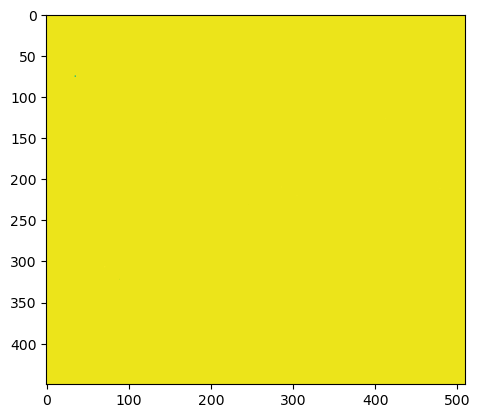

In [30]:
plt.imshow(means_mov_test_norm_local_df_filt_local[70,15,...])

In [31]:
means_mov_test_norm_local_df_filt_scale = means_mov_test_norm_local_df_filt/(means_mov_test_norm_local_df_filt2/np.mean(means_mov_test_norm_local_df_filt2,axis=0))

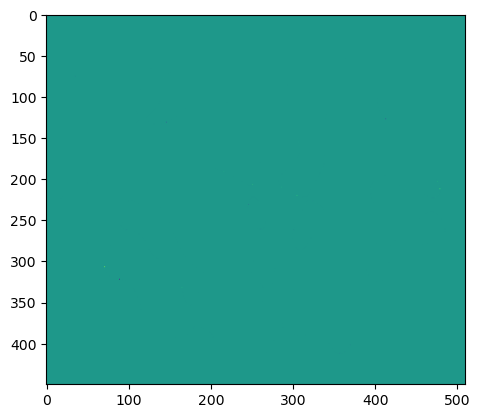

In [32]:
plt.imshow(means_mov_test_norm_local_df_filt_scale[70,15,...])

In [ ]:
means_mov_filt_norm_local_df = means_mov_filt-means_mov_filt2

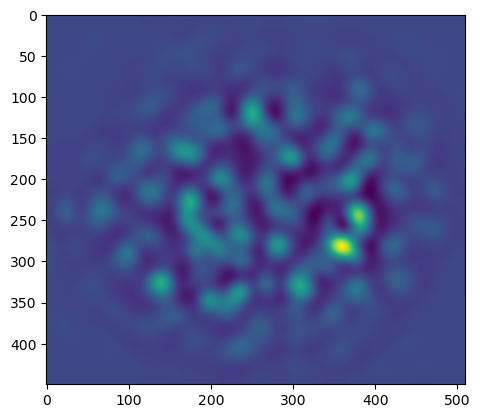

In [11]:
plt.imshow(means_mov_test_norm_local_df_filt[70,15,...])

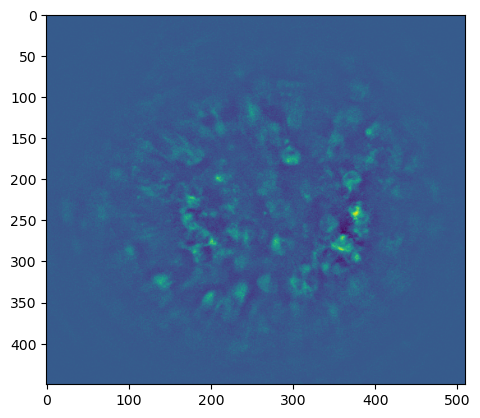

In [12]:
plt.imshow(means_mov_test_norm_local_df[70,15,...])

In [20]:
means_mov_test_norm_local_df_scale = means_mov_test_norm_local_df/(means_mov_test_norm_local_df_filt/np.mean(means_mov_test_norm_local_df_filt,axis=0))

In [22]:
means_mov_test_norm_local_df_scale[70,15,200,200]

1533.8081

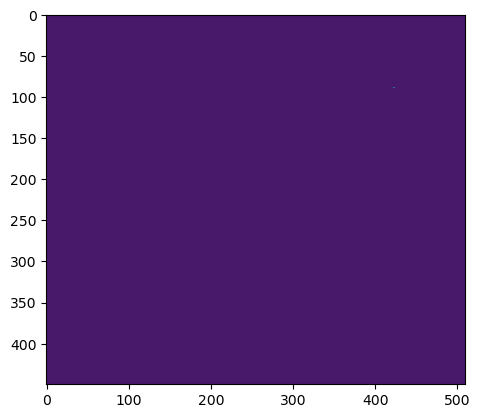

In [23]:
plt.imshow((means_mov_test_norm_local_df_filt/np.mean(means_mov_test_norm_local_df_filt,axis=0))[70,15,...])

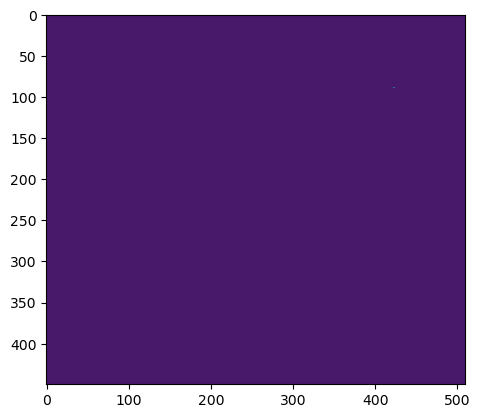

In [24]:
plt.imshow((means_mov_test_norm_local_df_filt[70,15,...]/np.mean(means_mov_test_norm_local_df_filt,axis=0)[15,...]))

In [27]:
(means_mov_test_norm_local_df_filt[70,15,...]/np.mean(means_mov_test_norm_local_df_filt,axis=0)[15,...])[200,200]

1.0411019

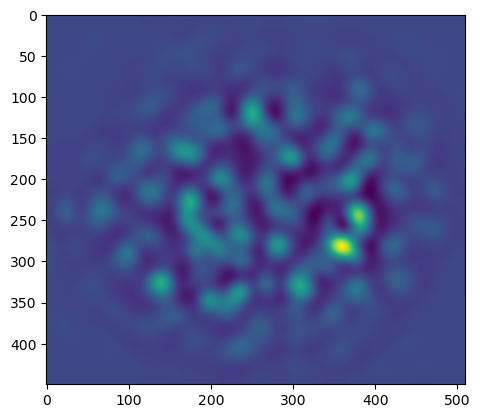

In [25]:
plt.imshow(means_mov_test_norm_local_df_filt[70,15,...])

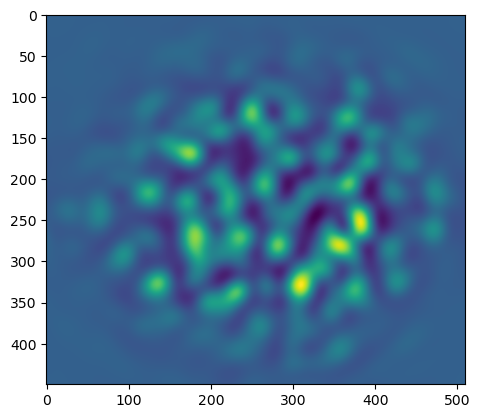

In [26]:
plt.imshow(np.mean(means_mov_test_norm_local_df_filt,axis=0)[15,...])

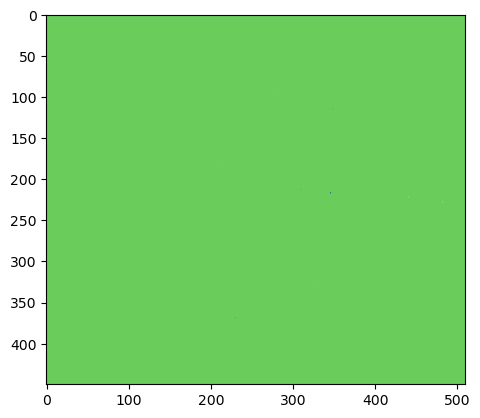

In [21]:
plt.imshow(means_mov_test_norm_local_df_scale[70,15,...])

In [17]:
means_mov_test_norm_local_df[70,15,200,200]

1596.8506

In [19]:
means_mov_test_norm_local_df_filt[70,15,200,200]

577.7872

In [18]:
np.mean(means_mov_test_norm_local_df_filt,axis=0)[15,200,200]

554.97656

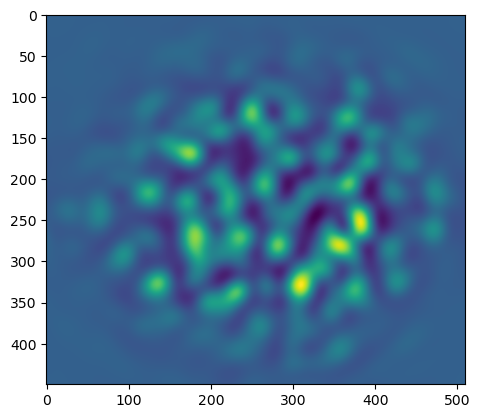

In [16]:
plt.imshow(np.mean(means_mov_test_norm_local_df_filt,axis=0)[15,...])

In [ ]:
means_mov_test
means_mov_test_filt
means_mov_test_filt2

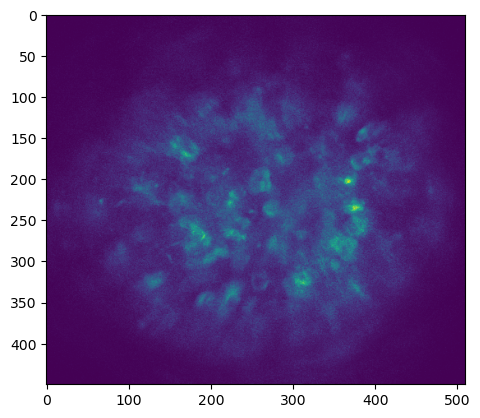

In [502]:
plt.imshow((means_mov_test/(means_mov_test_filt/np.mean(means_mov_test_filt,axis=0)))[10,15,...])

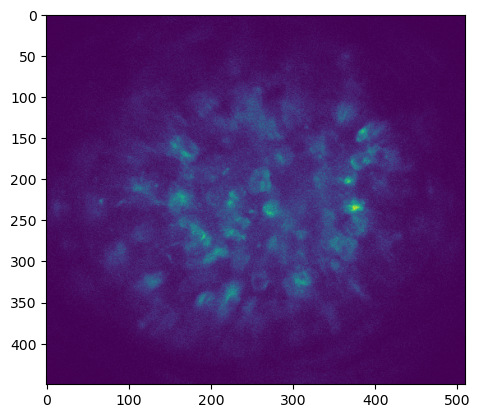

In [496]:
plt.imshow(means_mov_test[10,15,...])

In [ ]:
plt.imshow((means_mov_test)[10,15,...])

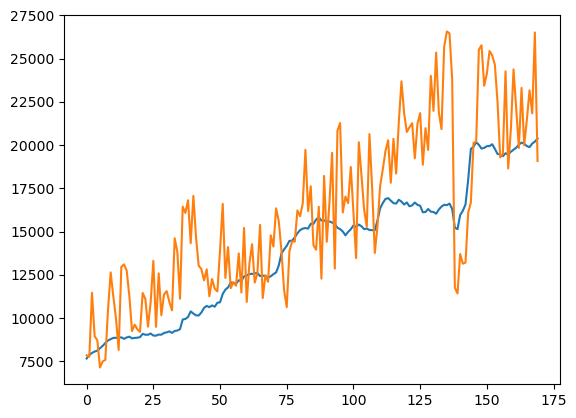

In [494]:
plt.plot(means_mov_test_filt[:,15,200,200])
plt.plot(means_mov_test[:,15,200,200])

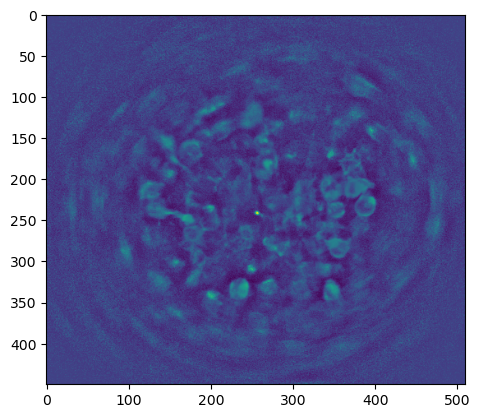

In [489]:
plt.imshow(((means_mov_test-means_mov_test_filt)/means_mov_test_filt)[120,12,...])

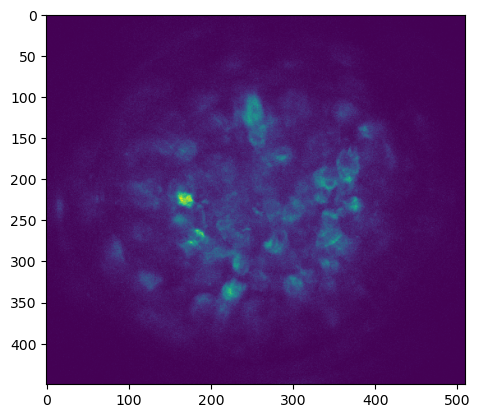

In [478]:
plt.imshow((means_mov_test_f.T/(np.mean(means_mov_test_f,axis=1)/np.mean(means_mov_test_f)).T).T.reshape(means_mov_test.shape)[10,12,...])

In [484]:
means_mov_test[120,12,200,200]

17428.096

In [485]:
(means_mov_test_f.T/(np.mean(means_mov_test_f,axis=1)/np.mean(means_mov_test_f)).T).T.reshape(means_mov_test.shape)[120,12,200,200]

14591.657

In [ ]:
np.save(f'{means_path}/means_movie.npy',np.array(means_movie))

In [3]:
means_mov_test = np.load(file_dir_l[0] + 'means_movie.npy')

In [4]:
means_mov_test.shape

(170, 30, 450, 510)

In [472]:
means_mov_test_filt.dtype

dtype('float32')

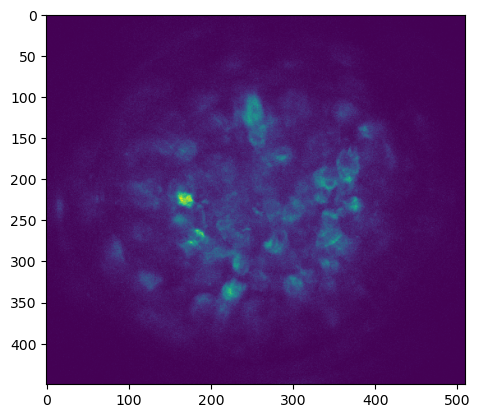

In [462]:
plt.imshow(means_mov_test[10,12,...])

CPU times: user 2min 5s, sys: 2.28 s, total: 2min 7s
Wall time: 2min 7s


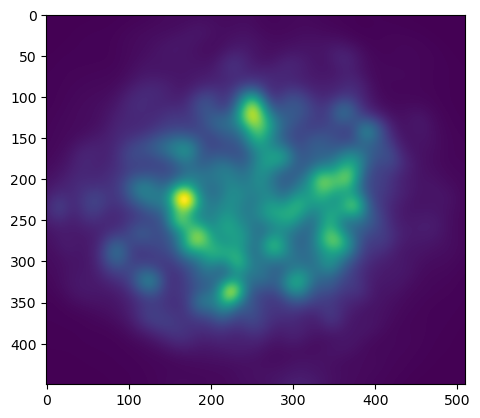

In [5]:
%%time
means_mov_test_filt = gaussian_filter(means_mov_test,sigma=[0,1.25,10,10],mode='nearest')
plt.imshow(means_mov_test_filt[10,12,...])

CPU times: user 3min 48s, sys: 2.22 s, total: 3min 51s
Wall time: 3min 51s


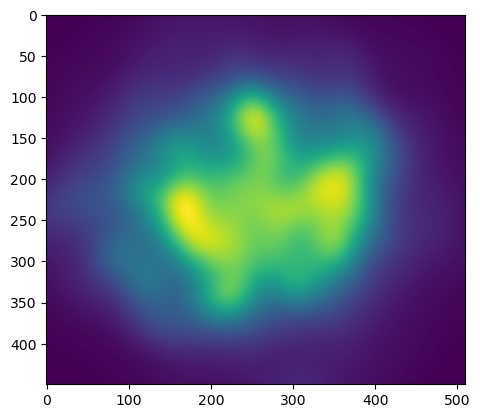

In [6]:
%%time
means_mov_test_filt2 = gaussian_filter(means_mov_test,sigma=[0,2.5,20,20],mode='nearest')
plt.imshow(means_mov_test_filt2[10,12,...])

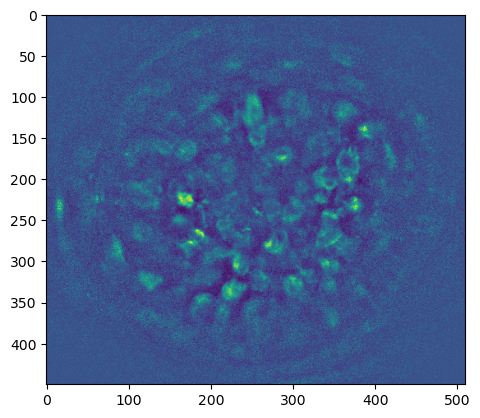

In [470]:
plt.imshow(means_mov_test[10,12,...]/means_mov_test_filt[10,12,...])

In [463]:
means_mov_test_f = means_mov_test.reshape((means_mov_test.shape[0],-1))
means_mov_test_f.shape

(170, 6885000)

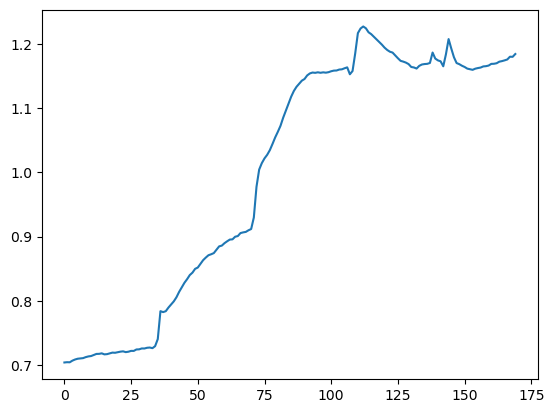

In [465]:
plt.plot(np.mean(means_mov_test_f,axis=1)/np.mean(means_mov_test_f))

In [449]:
m=16
warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs_l[m][0]))[1])
ref_frames = ref_frames_l[m]
mov_means = mov_means_l[m]

coor0 = tif_imread(os.path.join(data_dirs_l[m][0], 'segtrack/segs/ch0/'+str(mov_means[0])+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
img0 = tif_imread(warp_dir+f'/bs_image0.tiff')
tif_imwrite(warp_dir+f'/bs_image0_coor.tiff', ((coor0[ref_frames_l[m][0]-1,...]!=0).astype('float32')*(2**16-1)+img0))

for n in tqdm([1,2]):
    if n==0:
        tree = ET.parse(warp_dir+f'/dataset.xml')
    else:
        tree = ET.parse(warp_dir+f'/dataset{n:01}.xml')
    root = tree.getroot()
    w_mat = np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4])
    w_mat_i = np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
    w_mat[0,3] = w_mat_i[1,3]
    w_mat[1,3] = w_mat_i[0,3]
    
    img = tif_imread(warp_dir+f'/bs_image{n+1:01}.tiff').transpose([1,2,0])
    img_warp = affine_transform(img,w_mat)

    tif_imwrite(warp_dir+f'/bs_image{n+1:01}_rot.tiff', img_warp.transpose([2,0,1]))

    coorn = tif_imread(os.path.join(data_dirs_l[m][n+1], 'segtrack/segs/ch0/'+str(mov_means[n+1])+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
    img_c = (coorn[ref_frames_l[m][n+1]-1,...]!=0).transpose([1,2,0]).astype('float32')*(2**16-1)+img
    img_c_warp = affine_transform(img_c,w_mat)

    tif_imwrite(warp_dir+f'/bs_image{n+1:01}_rot_coor.tiff', img_c_warp.transpose([2,0,1]))

  0%|          | 0/2 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ssd_cache/pkalugin/stitch_warp/20230824_SL1PL60/dataset2.xml'

In [453]:
n=0
if n==0:
    tree = ET.parse(warp_dir+f'/dataset.xml')
else:
    tree = ET.parse(warp_dir+f'/dataset{n:01}.xml')
root = tree.getroot()
w_mat = np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4])
w_mat_i = np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
w_mat[0,3] = w_mat_i[1,3]
w_mat[1,3] = w_mat_i[0,3]

img = tif_imread(warp_dir+f'/bs_image{n+1:01}.tiff').transpose([1,2,0])
img_warp = affine_transform(img,w_mat)

tif_imwrite(warp_dir+f'/bs_image{n+1:01}_rot.tiff', img_warp.transpose([2,0,1]))

coorn = tif_imread(os.path.join(data_dirs_l[m][n+1], 'segtrack/segs/ch0/'+str(mov_means[n+1])+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
img_c = (coorn[ref_frames_l[m][n+1]-1,:,:449,...]!=0).transpose([1,2,0]).astype('float32')*(2**16-1)+img
img_c_warp = affine_transform(img_c,w_mat)

tif_imwrite(warp_dir+f'/bs_image{n+1:01}_rot_coor.tiff', img_c_warp.transpose([2,0,1]))

In [452]:
coorn.shape

(36, 30, 450, 510)

In [437]:
img = tif_imread(warp_dir+f'/bs_image{n+1:01}.tiff').transpose([1,2,0])
img.shape

(449, 510, 30)

In [394]:
data_dirs_l[0]

['/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse',
 '/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/wells']

In [426]:
warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs_l[m][0]))[1])

In [427]:
m=0
coor0 = tif_imread(os.path.join(data_dirs_l[m][0], 'segtrack/segs/ch0/'+str(mov_mean)+f'_mean_warped_/cellpose_model_1_o_relab042323_flow_aniso4_st0p4_blTrue_intFalse_3DeeC/seg/coord_3d_com_movie.tiff'))
img0 = tif_imread(warp_dir+f'/bs_image0.tiff')


In [433]:
((coor0[ref_frames_l[m][0]-1,...]!=0).transpose([1,2,0]).astype('float32')*(2**16-1)+img0.transpose([1,2,0])).transpose([2,0,1]).shape

(30, 450, 510)

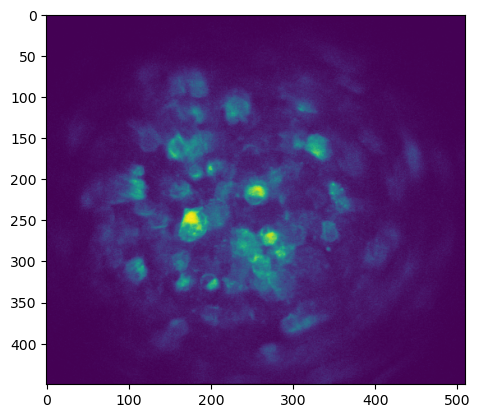

In [406]:
plt.imshow(img0[10,...])

In [411]:
np.amax((coor0[ref_frames_l[m][0]-1,10,...]!=0).astype('float32'))

1.0

In [412]:
np.amax(img0)

65500.29

In [418]:
np.amax((coor0[ref_frames_l[m][0]-1,10,...]!=0).astype('float32')*(2**16-1))

65535.0

In [377]:
m=1
base_dir = r'/mnt/ssd_cache/pkalugin/stitch_warp'
warp_dir = os.path.join(base_dir,os.path.split(os.path.dirname(data_dirs_l[m][0]))[1])
ref_frames = ref_frames_l[m]
mov_means = mov_means_l[m]

In [378]:
n=0
print(warp_dir+f'/bs_image{n+1:01}.tiff')
if n==0:
    print(warp_dir+f'/dataset.xml')
else:
    print(warp_dir+f'/dataset{n:01}.xml')

/mnt/ssd_cache/pkalugin/stitch_warp/231107_DG44PL58/bs_image1.tiff
/mnt/ssd_cache/pkalugin/stitch_warp/231107_DG44PL58/dataset.xml


In [379]:
import xml.etree.ElementTree as ET
tree = ET.parse(warp_dir+f'/dataset.xml')
root = tree.getroot()

In [380]:
for child in root[2][1][0]:
    print(child.tag, child.attrib)

Name {}
affine {}


In [381]:
w_mat = np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4])
#w_mat_x = w_mat[0,3]
#w_mat[0,3] = w_mat[1,3]
#w_mat[1,3] = w_mat_x
#w_mat[:3,:3]
#w_mat[:,3]
#w_mat[1,3] = -w_mat[1,3]
#w_mat[0,3] = w_mat[0,3]+100

In [382]:
w_mat

array([[-8.91006524e-01, -4.53990500e-01,  0.00000000e+00,
         5.87482937e+02],
       [ 4.53990500e-01, -8.91006524e-01,  0.00000000e+00,
         3.31996527e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00]])

In [383]:
w_mat_i = np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
w_mat_i

array([[-8.91006524e-01,  4.53990500e-01, -0.00000000e+00,
         3.72727860e+02],
       [-4.53990500e-01, -8.91006524e-01, -0.00000000e+00,
         5.62522744e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [384]:
w_mat[0,3] = w_mat_i[1,3]
w_mat[1,3] = w_mat_i[0,3]
w_mat

array([[-8.91006524e-01, -4.53990500e-01,  0.00000000e+00,
         5.62522744e+02],
       [ 4.53990500e-01, -8.91006524e-01,  0.00000000e+00,
         3.72727860e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00]])

In [385]:
from scipy.spatial.transform import Rotation
r = Rotation.from_matrix(w_mat[:3,:3])
r.as_euler('xyz')[2]

2.670353755551323

In [257]:
np.pi/np.arccos(w_mat[0,0])

1.6071428571428563

In [168]:
np.append(np.eye(3),w_mat[:,3][:,np.newaxis],axis=1)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.99611750e+02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         8.05431541e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -5.65534446e-01]])

In [193]:
np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0)

array([[-3.74606593e-01, -9.27183855e-01,  0.00000000e+00,
         5.99611750e+02],
       [ 9.27183855e-01, -3.74606593e-01,  0.00000000e+00,
         8.05431541e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        -5.65534446e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [386]:
%%time
from scipy.ndimage import affine_transform
im0 = tif_imread(warp_dir+f'/bs_image0.tiff').transpose([1,2,0])
im1 = tif_imread(warp_dir+f'/bs_image1.tiff').transpose([1,2,0])
#im1_warp = affine_transform(im1,np.array(root[2][1][0][1].text.split()).astype(np.float64).reshape([3,4]))
im1_warp = affine_transform(im1,w_mat)
im0_warp = affine_transform(im0,np.linalg.inv(np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0)))
#im1_warp = affine_transform(im1,w_mat[:3,:3])
#im1_warp = affine_transform(im1_warp,np.append(np.eye(3),w_mat[:,3][:,np.newaxis],axis=1))

CPU times: user 5.15 s, sys: 85.3 ms, total: 5.23 s
Wall time: 5.23 s


In [210]:
from skimage import transform
im0 = tif_imread(warp_dir+f'/bs_image0.tiff')
im1 = tif_imread(warp_dir+f'/bs_image1.tiff')
tform = transform.AffineTransform(matrix=np.append(w_mat,np.array([0,0,0,1])[np.newaxis,:],axis=0))
im1_warp = transform.warp(im1,tform)

In [391]:
im1_warp.dtype

dtype('float32')

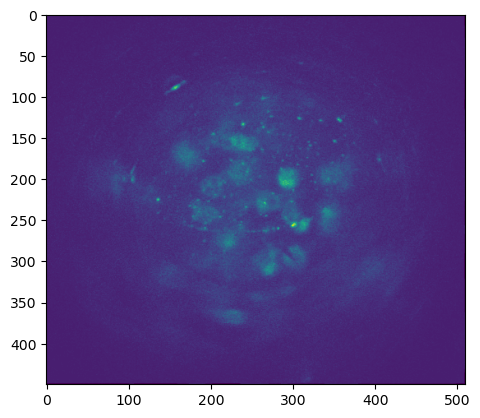

In [387]:
plt.imshow(im0[:,:,5])

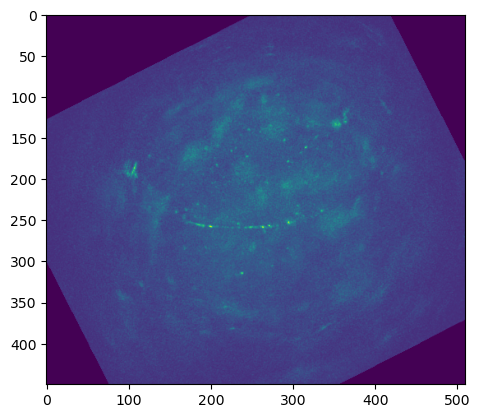

In [388]:
plt.imshow(im1_warp[:,:,5])

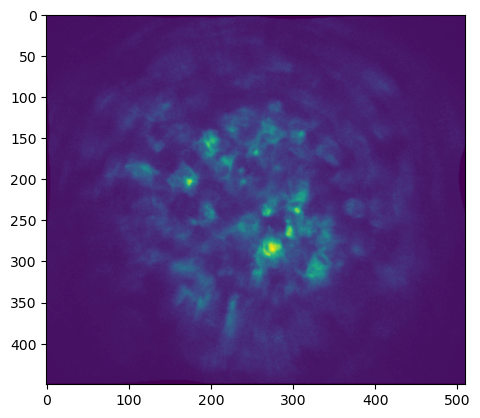

In [368]:
plt.imshow(im1[:,:,15])

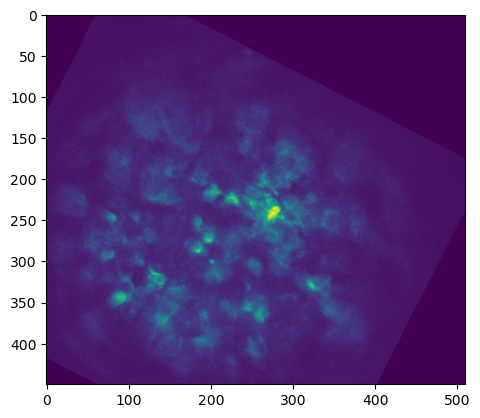

In [237]:
plt.imshow(im0_warp[:,:,15])

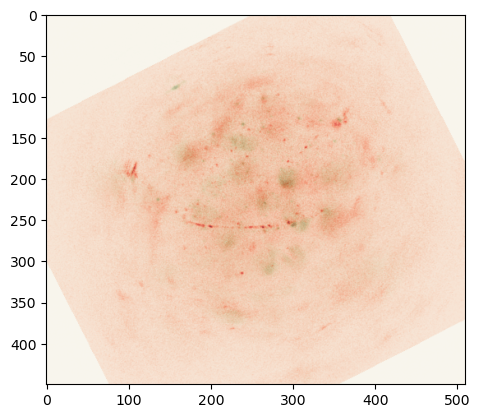

In [389]:
plt.imshow(im0[:,:,5],'Greens')
plt.imshow(im1_warp[:,:,5],'Reds',alpha=0.7)

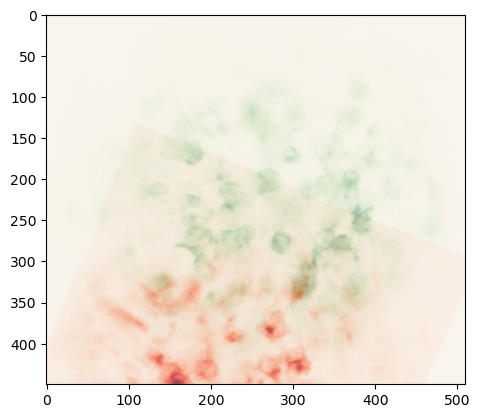

In [269]:
plt.imshow(im0[:,:,15],'Greens')
plt.imshow(im1_warp[:,:,15],'Reds',alpha=0.7)

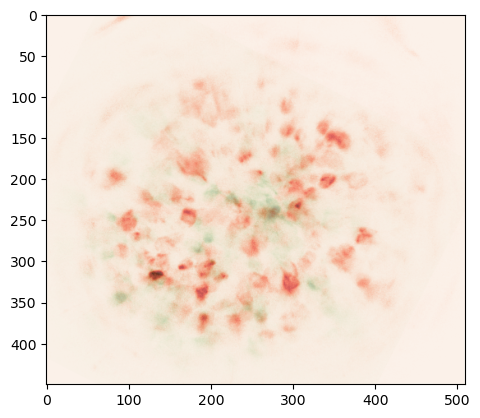

In [239]:
plt.imshow(im0_warp[:,:,15],'Greens')
plt.imshow(im1[:,:,15],'Reds',alpha=0.7)

In [34]:
os.path.split(os.path.dirname(data_dir))[1]+f'/bs_image{n+1:01}.tiff'

'20230817_SL1PL55/bs_image3.tiff'

In [33]:
os.path.split(os.path.dirname(data_dir))[1]+'/bs_'+os.path.split(data_dir)[1]+f'_image{ref_frame:03}.tiff'

'20230817_SL1PL55/bs_wells101_image039.tiff'

In [30]:
os.path.split(os.path.dirname(os.path.dirname(data_dir)))[1] + '_' + os.path.split(os.path.dirname(data_dir))[1]

'slice_20230817_SL1PL55'

In [32]:
data_dir

'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/wells101'

In [9]:
data_dir = data_dirs_l[0][0]
ref_frame = ref_frames_l[0][0]
mov_mean = mov_means_l[0][0]

frame_dir = os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_mean)+'_mean_warped_')
frame_dir + f'/image{ref_frame:03}.tiff'

'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse/segtrack/tiffs/ch0/52_mean_warped_/image085.tiff'

In [10]:
frame_src = os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_mean)+f'_mean_warped_/image{ref_frame:03}.tiff')
frame_src

'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/mouse/segtrack/tiffs/ch0/52_mean_warped_/image085.tiff'

In [15]:
os.path.split(data_dir)[1]

'mouse'

In [13]:
base_dir = os.path.dirname(data_dir)
os.path.join(base_dir,'stitch_warp')

'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/stitch_warp'

In [19]:
frame_src = os.path.join(data_dir, 'segtrack/tiffs/ch0/'+str(mov_mean)+f'_mean_warped_/image{ref_frame:03}.tiff')
frame_dst = os.path.join(base_dir,'stitch_warp/bs_'+os.path.split(data_dir)[1]+f'_image{ref_frame:03}.tiff')

In [20]:
frame_dst

'/mnt/nasquatch/data/2p/peter/in_vivo/231108_DG61PL62/stitch_warp/bs_mouse_image085.tiff'

In [27]:
n = 0
frame_dst2 = os.path.join(base_dir,f'stitch_warp/bs_image{n+1:01}.tiff')
frame_dst2

'/mnt/nasquatch/data/2p/peter/slice/20230817_SL1PL55/stitch_warp/bs_image1.tiff'